In [1]:
import os, sys
module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

from MicroneurographyDataloader import *
from _external.WHVPNet_pytorch.networks import *
from _external.WHVPNet_tensorflow.VPLayer import *
from spike_classification import *
from XAIProject import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.collections import LineCollection
import matplotlib.ticker as mticker
import torch.nn.functional as F
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
import innvestigate

In [2]:
"""
Load the model.
"""

model_name = '_trained_models/widnow_15_overlapping_11_hidden_6_nweight_4_id_6'

dtype = torch.float64
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
window_size = 15
overlapping_size = 11

MNG_dataloader = MicroneurographyDataloader()
path = f'window_{window_size}_overlap_{overlapping_size}_corrected.pkl'
MNG_dataloader.load_samples_and_labels_from_file(path)

dataloaders = MNG_dataloader.sequential_split_with_resampling(1024)

sample_windows = torch.tensor(MNG_dataloader.raw_data_windows, dtype=torch.float64).unsqueeze(1)
n_channels, n_in = sample_windows[0].shape
n_out = len(MNG_dataloader.binary_labels_onehot[0])
num_VP_features = 6
num_weights = 4
fcn_neurons = 6
affin = torch.tensor([6 / n_in, -0.3606]).tolist()
weight = ((torch.rand(num_weights)-0.5)*8).tolist()


model = VPNet(n_in, n_channels, num_VP_features, VPTypes.FEATURES, affin + weight, WeightedHermiteSystem(n_in, num_VP_features, num_weights), [fcn_neurons], n_out, device=device, dtype=dtype)
model.load_state_dict(torch.load(model_name, weights_only=True))


<All keys matched successfully>

In [ ]:
"""
Evaluation.
"""
dataset_name='val' # 'or test
decision_boundary = 0.8
class_weights = torch.tensor([0.003, 0.997]).to(device)
weighted_criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
criterion = VPLoss(weighted_criterion, 0.1)
accuracy, loss, binary_labels, multiple_labels, predicted_classes, predicted_probabilities = test(model, dataloaders[f'{dataset_name}_loader'], criterion, decision_boundary)
compute_common_metrics(binary_labels, predicted_classes)
compute_merged_metrics(binary_labels, predicted_classes, multiple_labels, proximity_rule=True, latency_threshold=3)
#create_decision_ceratinty_boxplots(binary_labels, multiple_labels, predicted_classes, predicted_probabilities)


Window-wise multi-class comparison
{
    "Label 0": {
        "TN": 387548,
        "FP": 15258
    },
    "Label 1": {
        "TP": 259,
        "FN": 0
    },
    "Label 2": {
        "TP": 255,
        "FN": 0
    },
    "Label 3": {
        "TP": 236,
        "FN": 17
    }
}
Accuracy: 96.22%, loss: 10.2869
Weighted Balanced Accuracy: 0.9700
Common Metrics
{
    "precision": 0.0469,
    "recall": 0.9778,
    "fpr": 0.0379,
    "roc_auc": 0.97,
    "confusion_matrix": {
        "TN": 387548,
        "FP": 15258,
        "FN": 17,
        "TP": 750
    }
}
Merged Metrics
{
    "metrics": {
        "recall": 0.945273631840796
    },
    "ground_truth_positive": {
        "sum": 201,
        "length_counter": {
            "5": 28,
            "4": 108,
            "3": 65
        }
    },
    "true_positive": {
        "sum": 190,
        "length_counter": {
            "4": 98,
            "3": 3,
            "8": 2,
            "7": 49,
            "5": 27,
            "6": 8,
    

{'metrics': {'recall': 0.945273631840796},
 'ground_truth_positive': {'sum': 201,
  'length_counter': {5: 28, 4: 108, 3: 65}},
 'true_positive': {'sum': 190,
  'length_counter': {4: 98, 3: 3, 8: 2, 7: 49, 5: 27, 6: 8, 9: 1, 2: 2}},
 'false_positive': {'sum': 630,
  'length_counter': {2: 224, 4: 204, 3: 126, 5: 58, 6: 12, 10: 1, 7: 4, 9: 1}},
 'false_negative': {'sum': 11, 'length_counter': {5: 2, 3: 4, 4: 5}}}

In [4]:
"""
Get samples and timestamps from the dataloader.
"""

sample_windows = []
for data in dataloaders[f'{dataset_name}_loader']:
    x, labels, multiple = data
    sample_windows.append(x.cpu())
sample_windows = torch.cat(sample_windows).squeeze(1)
timestamp_windows = dataloaders[f'{dataset_name}_timestamps']

In [5]:
""" 
Get the outputs of the VPLayer.
"""
Phi, _ = model.vp_layer.fun_system(model.vp_layer.params)
Phip = torch.linalg.pinv(Phi, rtol=1e-15)
sample_windows = sample_windows.to(device)
vplayer_output = sample_windows @ Phip

In [33]:
""" 
Plot the modified Hermite basis functions one by one.
"""
def dynamic_linewidth(x, x_min, x_max):
    center = (x_max + x_min) / 2
    width_factor = 1 - (abs(x - center) / (x_max - x_min))**2
    return 6 * width_factor

hermite_tensor = Phi.cpu().detach().numpy()
x_values = np.linspace(-5, 5, 15) 
for i in range(Phi.shape[0]):
    plt.figure(figsize=(6,5))
    y_values = hermite_tensor[i]

    y_min, y_max = np.round(np.min(y_values), 0), np.round(np.max(y_values), 0)
    x_min, x_max = np.round(np.min(x_values), 0), np.round(np.max(x_values), 0)

    color_value = (i + 1) / (Phi.shape[0] + 1)
    color = plt.cm.viridis(0.25 + color_value * 0.5)
    
    for j in range(len(x_values) - 1):
        linewidth = dynamic_linewidth(x_values[j], x_values[0], x_values[-1])
        plt.plot(x_values[j:j+2], y_values[j:j+2], label=f'Hermite Basis {i+1}' if j == 0 else "", 
                     color=color, linewidth=12)

    plt.grid(axis='y')
    plt.xticks([x_min, 0, x_max], fontsize=40)
    plt.yticks([y_min, 0, y_max], fontsize=40)
    plt.gcf().subplots_adjust(left=0.2)

    # set orange border for the most important functions
    if i in [0, 2]:
        plt.gca().spines['top'].set_linewidth(8)
        plt.gca().spines['top'].set_edgecolor('orange')
        plt.gca().spines['right'].set_linewidth(8)
        plt.gca().spines['right'].set_edgecolor('orange')
        plt.gca().spines['bottom'].set_linewidth(8)
        plt.gca().spines['bottom'].set_edgecolor('orange')
        plt.gca().spines['left'].set_linewidth(8)
        plt.gca().spines['left'].set_edgecolor('orange')


    #plt.tight_layout()
    plt.show()
    plt.close()

In [14]:
"""
Create the fully connected network from the WHVPNet in tensorflow and load the weights of the pytorch model into the tensorflow model.
"""
def create_tf_fully_connected():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(num_VP_features,)),
        tf.keras.layers.Dense(fcn_neurons, activation ='relu', use_bias=True),
        tf.keras.layers.Dense(2, activation = 'softmax', use_bias=True),
    ])
    return model

pytorch_model_weights = torch.load(model_name, weights_only=True)
weights_fc1 = pytorch_model_weights['fcnn.1.weight'].cpu().numpy()
biases_fc1 = pytorch_model_weights['fcnn.1.bias'].cpu().numpy()

weights_fc2 = pytorch_model_weights['fcnn.3.weight'].cpu().numpy()
biases_fc2 = pytorch_model_weights['fcnn.3.bias'].cpu().numpy() 

weights_fc1_tf = np.transpose(weights_fc1)
weights_fc2_tf = np.transpose(weights_fc2)

tf_fcn_model = create_tf_fully_connected()

tf_fcn_model.layers[0].set_weights([weights_fc1_tf, biases_fc1])
tf_fcn_model.layers[1].set_weights([weights_fc2_tf, biases_fc2])
tf_fcn_model.compile(optimizer='adam', 
                 loss='categorical_crossentropy', 
                 metrics=['accuracy'])
tf_fcn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6)                 42        
                                                                 
 dense_1 (Dense)             (None, 2)                 14        
                                                                 
Total params: 56 (224.00 Byte)
Trainable params: 56 (224.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
"""
Check if the two models have the same predictions.
"""
def convert_to_class_labels(predictions):
    class_labels = (predictions[:, 1] >= decision_boundary).astype(int)
    return class_labels

with torch.no_grad():
    pytorch_fcn_output = model.fcnn(vplayer_output).cpu().numpy() 
pytorch_fcn_classes = convert_to_class_labels(pytorch_fcn_output)

print("PyTorch output:\n", pytorch_fcn_classes[:10])

tf_fcn_input = vplayer_output.cpu().detach().numpy().astype(np.float64)
tf_fcn_output = tf_fcn_model.predict(tf_fcn_input)
tf_fcn_classes = convert_to_class_labels(tf_fcn_output)

print("TensorFlow output:\n", tf_fcn_classes[:10])

equal_predictions = np.sum(pytorch_fcn_classes == tf_fcn_classes)
total_predictions = len(pytorch_fcn_classes)
accuracy = equal_predictions / total_predictions
print(f'Similarity to each other: {accuracy:.4f}')

PyTorch output:
 [0 0 0 0 0 0 0 0 0 1]


c:\Users\darab\anaconda3\envs\microneurography\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


TensorFlow output:
 [0 0 0 0 0 0 0 0 0 1]
Similarity to each other: 1.0000


In [16]:
"""
Create the WHVPNet in tensorflow and load the weights of the pytorch model into the tensorflow model.
"""
VP_INIT = [1.0, -6.0]
WEIGHTS = np.random.uniform(-7, 2, num_weights)
VP_INIT.extend(list(WEIGHTS))
VP_PEN = 0.1
pytorch_model_weights = torch.load(model_name, weights_only=True)
class_weights = tf.constant([0.3, 0.7])

def weighted_categorical_crossentropy(y_true, y_pred):
    weights = tf.reduce_sum(class_weights * y_true, axis=-1)
    loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    return loss * weights

def create_tf_WHVPNet():
    keras_model = tf.keras.Sequential()
    keras_model.add(tf.keras.Input(shape=window_size))
    keras_model.add(VPLayer_tf(window_size, num_VP_features, VP_INIT, VP_PEN, name='vplayer'))
    keras_model.add(tf.keras.layers.Dense(6, activation='relu', name='linear1'))
    keras_model.add(tf.keras.layers.Dense(2, activation='softmax', name='linear2'))
    return keras_model

tf_WHVPNet_model = create_tf_WHVPNet()

weights_vp = pytorch_model_weights['vp_layer.params'].cpu().numpy()

weights_fc1 = pytorch_model_weights['fcnn.1.weight'].cpu().numpy()
biases_fc1 = pytorch_model_weights['fcnn.1.bias'].cpu().numpy()

weights_fc2 = pytorch_model_weights['fcnn.3.weight'].cpu().numpy()
biases_fc2 = pytorch_model_weights['fcnn.3.bias'].cpu().numpy() 

weights_fc1_tf = np.transpose(weights_fc1)
weights_fc2_tf = np.transpose(weights_fc2)

weight_splits = np.split(weights_vp, num_VP_features)
tf_WHVPNet_model.layers[0].set_weights(weight_splits)
tf_WHVPNet_model.layers[1].set_weights([weights_fc1_tf, biases_fc1])
tf_WHVPNet_model.layers[2].set_weights([weights_fc2_tf, biases_fc2])
tf_WHVPNet_model.compile(optimizer='adam', 
                 loss=weighted_categorical_crossentropy, 
                 metrics=['accuracy'])


In [40]:
for layer in tf_WHVPNet_model.layers:
    layer_name = layer.name
    print(f"Layer: {layer_name}")
    weights = layer.get_weights()
    for weight in weights:
        print(weight)

Layer: vplayer
[0.29458204]
[-0.1223308]
[0.11282437]
[2.034438]
[-2.4693894]
[-2.4352572]
Layer: linear1
[[ 2.3768773   0.03304804 -0.5201561  -3.1334753   0.13251445  0.50877136]
 [-1.1455201   0.97150946 -0.7078586  -0.48276868 -0.23640159  0.6311314 ]
 [ 0.49147156 -0.5368033  -0.37027687  0.7426802  -0.61502874  0.7837017 ]
 [-0.9831456  -0.29419735  0.10253707  0.18991917  1.9077662   0.27465516]
 [ 0.99615663  0.06414719 -0.9037405   0.1109243  -2.4078267   0.39227232]
 [-0.5289753   1.3333359  -0.694927   -2.527189   -0.56070113 -1.1526153 ]]
[-0.4631518   1.8874186  -0.56024146 -0.88515073 -0.4086451  -1.7952754 ]
Layer: linear2
[[-2.2695105   2.0327873 ]
 [ 2.0888305  -2.1858885 ]
 [-0.39287362  0.70710963]
 [-2.56295     2.157705  ]
 [-3.4237921   3.0504346 ]
 [-1.2937528   1.6473842 ]]
[ 1.0751281 -1.0423357]


In [41]:
for layer_name, weights in pytorch_model_weights.items():
    print(f"Layer: {layer_name}")
    print(weights.cpu().numpy()) 

Layer: vp_layer.params
[ 0.29458203 -0.1223308   0.11282437  2.0344379  -2.46938941 -2.43525714]
Layer: fcnn.1.weight
[[ 2.37687736 -1.14552004  0.49147157 -0.98314559  0.99615662 -0.52897529]
 [ 0.03304804  0.97150944 -0.53680331 -0.29419734  0.06414719  1.33333587]
 [-0.5201561  -0.70785864 -0.37027686  0.10253708 -0.90374054 -0.69492697]
 [-3.13347536 -0.48276868  0.7426802   0.18991918  0.1109243  -2.52718904]
 [ 0.13251444 -0.23640159 -0.61502873  1.90776625 -2.40782658 -0.56070111]
 [ 0.50877135  0.63113139  0.78370171  0.27465515  0.39227231 -1.15261536]]
Layer: fcnn.1.bias
[-0.46315182  1.8874186  -0.56024145 -0.88515075 -0.40864509 -1.79527545]
Layer: fcnn.3.weight
[[-2.26951053  2.08883037 -0.39287361 -2.56294982 -3.42379221 -1.29375282]
 [ 2.03278731 -2.18588841  0.70710961  2.15770502  3.05043449  1.64738419]]
Layer: fcnn.3.bias
[ 1.07512809 -1.04233571]


In [17]:
"""
Check if the two models have the same predictions.
"""
sample_windows = sample_windows.to(device)
with torch.no_grad():
    pytorch_output = model(sample_windows)[0].cpu().numpy() 

pytorch_classes = convert_to_class_labels(pytorch_output)

print("PyTorch output:\n", pytorch_classes[:10])

tf_input = sample_windows.cpu().detach().numpy().astype(np.float64)
tf_output = tf_WHVPNet_model.predict(tf_input, batch_size=1024)
tf_classes = convert_to_class_labels(tf_output)

print("TensorFlow output:\n", tf_classes[:10])

equal_predictions = np.sum(pytorch_classes == tf_classes)
total_predictions = len(pytorch_classes)

accuracy = equal_predictions / total_predictions
print(f'Similarity to each other: {accuracy:.4f}')

tf_pytorch_same_indices = np.where(tf_classes == pytorch_classes)[0]

PyTorch output:
 [0 0 0 0 0 0 0 0 0 1]
TensorFlow output:
 [0 0 0 0 0 0 0 0 0 0]
Similarity to each other: 0.9694


In [18]:
""" 
Create the IG analyzer for the tf fcn model.
"""
tf_fcn_model_wo_softmax = innvestigate.model_wo_softmax(tf_fcn_model)
IG_analyzer_fcn = innvestigate.create_analyzer("integrated_gradients", tf_fcn_model_wo_softmax, neuron_selection_mode="max_activation",reference_inputs=0, steps = 64)
analyzation_fcn = IG_analyzer_fcn.analyze(tf_fcn_input)

In [19]:
""" 
Create the IG analyzer for the tf WHVPNet model.
"""

tf_WHVPNet_model_wo_softmax = innvestigate.model_wo_softmax(tf_WHVPNet_model)
IG_analyzer_full = innvestigate.create_analyzer("integrated_gradients", tf_WHVPNet_model_wo_softmax, neuron_selection_mode="max_activation",reference_inputs=0, steps = 64)
analyzation_full = IG_analyzer_full.analyze(tf_input)

In [20]:
binary_labels_np = binary_labels.numpy()
multiple_labels_np = multiple_labels.numpy()

In [ ]:
""" 
tf FCN: Load the attributes necessary for XAI into XAIProject.
"""
feature_extractor_XAIProject = XAIProject(model=tf_fcn_model,
                                          samples=tf_fcn_input,
                                          binary_labels=binary_labels_np,
                                          multiple_labels=multiple_labels_np,
                                          probabilities=tf_fcn_output,
                                          decision_boundary=decision_boundary)
feature_extractor_XAIProject.analyzer_output = analyzation_fcn

In [ ]:
""" 
tf WHVPNet: Load the attributes necessary for XAI into XAIProject.
"""
full_model_XAIProject = XAIProject(model=tf_WHVPNet_model,
                                          samples=tf_input,
                                          binary_labels=binary_labels_np,
                                          multiple_labels=multiple_labels_np,
                                          probabilities=tf_output,
                                          decision_boundary=decision_boundary)
full_model_XAIProject.analyzer_output = analyzation_full

In [32]:
import random
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as patches

def create_comparison_plot(project : XAIProject, binary_class_num, multiple_class_num, prediction_quality, random_, average_sample, average_analyzer):
    """
    project: XAI() instance that holds the analyzation

    class_num: the id of the class which should be shown on the plots

    prediction_quality: correct, incorrect, false_negative or false_positive in string format
    
    random_: boolean that shows if randomized single inputs should be shown on the plot
    
    average_sample: boolean that shows if the averaged original recording should be shown on the plot
    
    average_analyzer: boolean that shows if the averaged relevance scores shoul be shown on the plot

    """
    if prediction_quality == "correct": #
        if binary_class_num == 1 and multiple_class_num:
            indices_for_class = project.get_true_positive_indices_for_multiple_class(multiple_class_num)
            title = f"True positive predictions for multi-class {multiple_class_num}"
        elif binary_class_num == 1 and not multiple_class_num:
            indices_for_class = project.get_true_pos_prediction_indices()
            title = f"True positive predictions"
        elif binary_class_num == 0 and not multiple_class_num:
            indices_for_class = project.get_ture_neg_prediction_indices()
            title = f"True negative predictions"
    elif prediction_quality == "incorrect":
        indices_for_class = project.get_incorrect_prediction_indices_for_class(binary_class_num)
        title = f"Incorrect predictions for class {binary_class_num}"
    elif prediction_quality == "false_negative": #
        if binary_class_num == 1 and multiple_class_num:
            indices_for_class = project.get_false_negative_indices_for_multiple_class(multiple_class_num)
            title = f"False negative predictions for multi-class {multiple_class_num}"
        else:
            indices_for_class = project.get_false_negative_indices()
            title = f"False negative predictions"
        
    elif prediction_quality == "false_positive":
        indices_for_class = project.get_false_positive_indices()
        title = "False positive predictions"

    filtered_indices_for_class = np.intersect1d(indices_for_class, tf_pytorch_same_indices)
    input_for_class = project.samples[filtered_indices_for_class]
    analyzer_for_class = project.analyzer_output[filtered_indices_for_class]
    
    # input_for_class = project.samples[indices_for_class]
    # analyzer_for_class = project.analyzer_output[indices_for_class]

    analyzer_class_mean = np.mean(analyzer_for_class, axis=0, keepdims=True)
    input_class_mean = np.mean(input_for_class, axis=0, keepdims=True)

    if input_for_class.shape[0] == 0:
        return
    if random_ == True:
        random_indice_to_plot = random.sample(range(input_for_class.shape[0]), 1)[0]

    blue = (0 / 255, 139 / 255, 139 / 255)
    red = (139 / 255, 0 / 255, 0 / 255)
    num_steps = 256
    colors = [blue, (0.82745, 0.82745, 0.82745) ,red]

    custom_cmap = LinearSegmentedColormap.from_list("custom_colormap", colors, N=num_steps)

    fig = plt.figure(figsize=(8,4))
    ax = fig.add_subplot(111)
    avg_re = avg_an = single_legend = None
    if binary_class_num == 0:
        c = blue
    else:
        c = red
    if average_sample == True:
        #y = upsample(normalize(input_class_mean[0,:], -1, 1),5)
        y = upsample(input_class_mean[0,:],3)
        x = range(len(y))
        # ax.scatter(x, y, color=c, label="Input mean", s=10)
        ax.plot(x, y, color=c, label="Input mean", linewidth=1)
        avg_re = plt.Line2D([0], [0], color=c, linewidth=5, label='Recording mean')
    if average_analyzer == True:
        #y = upsample(normalize(analyzer_class_mean[0,:], -1, 1),5)
        y = upsample(analyzer_class_mean[0,:],3)
        x = range(len(y))
        #ax.scatter(x, y, color="dimgray", label="Analyzer mean", s=10)
        ax.plot(x, y, color="dimgray", label="Analyzer mean", linewidth=1)
        avg_an = plt.Line2D([0], [0], color="dimgray", linewidth=5, label='Analyzer mean')
    if random_ == True:
        #color_base = upsample(normalize(analyzer_for_class[random_indice_to_plot,:], -1, 1),5)
        #y = upsample(normalize(input_for_class[random_indice_to_plot,:], -1, 1), 5)
        color_base = upsample(analyzer_for_class[random_indice_to_plot,:],3)
        y = upsample(input_for_class[random_indice_to_plot,:], 3)
        x = range(len(y))
        cmap = plt.get_cmap(custom_cmap)
        norm = plt.Normalize(-1, 1)
        line_colors = cmap(color_base)
        ax.scatter(x, y, color=line_colors, label="Single input", s=20)
        sm = ScalarMappable(cmap=cmap)
        sm.set_array([])
        cbar = fig.colorbar(sm, ax=ax)
        cbar.set_label('Analyzer value')
        single_legend = plt.Line2D([0], [0], color=blue, linewidth=4)

    ax.set_xlim([0, len(y)])
    current_ticks = ax.get_xticks()
    adjusted_labels = current_ticks / 3
    ax.set_xticklabels([f"{int(label)}" for label in adjusted_labels]) 

    # for h_line in np.arange(-1,1.25,0.5):
    #     ax.axhline(y = h_line, color = "gray", linestyle = "dashed", linewidth = 0.25)

    # extra rectangle
    rect = patches.Rectangle((500, -1), 1500, 2, linewidth=1, edgecolor='orange', facecolor='none')
    ax.add_patch(rect)

    handle = [line for line in [avg_re, avg_an, single_legend] if line is not None]
    if random_ == False:
        ax.legend(handles=handle, fontsize=14)
    #ax.set_yticks(np.arange(-1, 1.25, 0.25))
    ax.set_title(title, fontsize=16)
    ax.set_xlabel("Time", fontsize=14)
    ax.set_ylabel("Amplitude", fontsize=14)
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
    ax.grid(False)
    fig.tight_layout()

C:\Users\darab\AppData\Local\Temp\ipykernel_26876\1894229522.py:110: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{int(label)}" for label in adjusted_labels])
C:\Users\darab\AppData\Local\Temp\ipykernel_26876\1894229522.py:110: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{int(label)}" for label in adjusted_labels])
C:\Users\darab\AppData\Local\Temp\ipykernel_26876\1894229522.py:110: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{int(label)}" for label in adjusted_labels])
C:\Users\darab\AppData\Local\Temp\ipykernel_26876\1894229522.py:110: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.

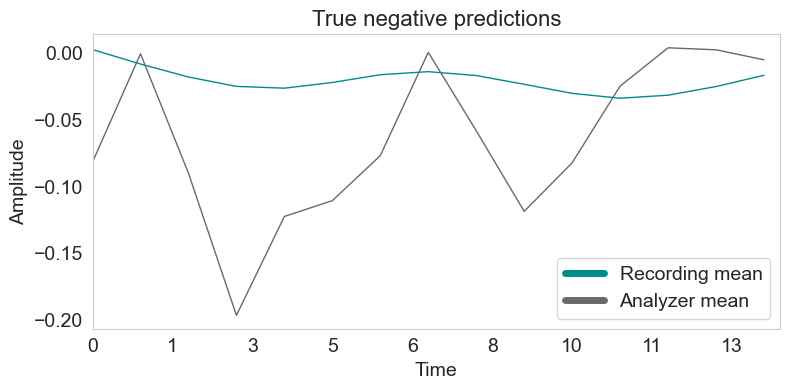

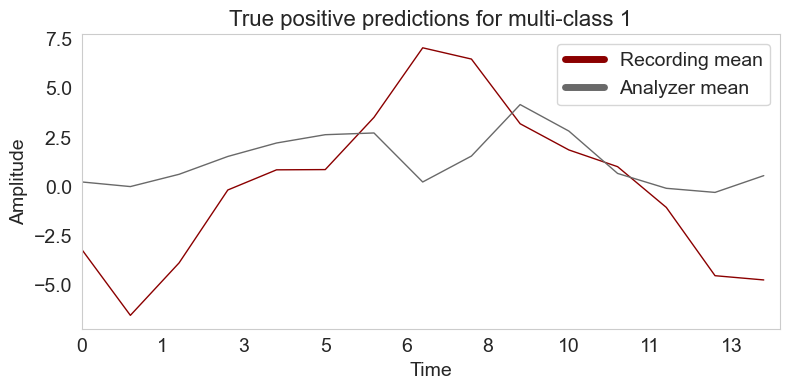

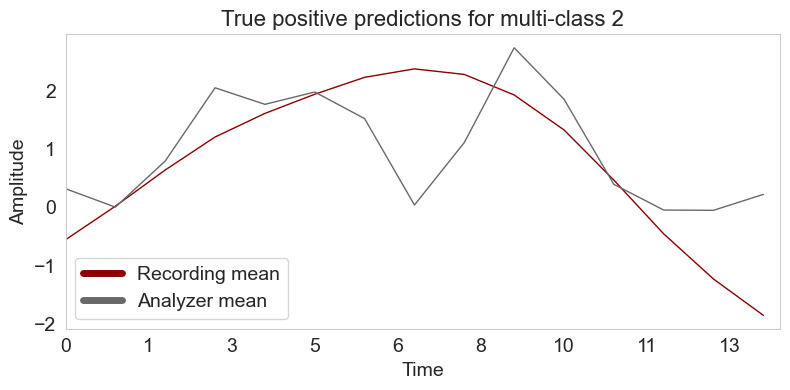

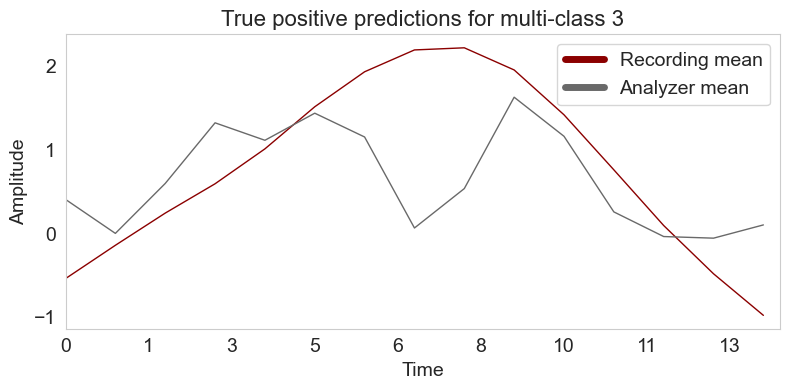

In [33]:
create_comparison_plot(full_model_XAIProject, binary_class_num = 0, multiple_class_num=False, prediction_quality = "correct", random_ = False, average_sample = True, average_analyzer = True)
create_comparison_plot(full_model_XAIProject, binary_class_num = 1, multiple_class_num=1, prediction_quality = "correct", random_ = False, average_sample = True, average_analyzer = True)
create_comparison_plot(full_model_XAIProject, binary_class_num = 1, multiple_class_num=2, prediction_quality = "correct", random_ = False, average_sample = True, average_analyzer = True)
create_comparison_plot(full_model_XAIProject, binary_class_num = 1, multiple_class_num=3, prediction_quality = "correct", random_ = False, average_sample = True, average_analyzer = True)

C:\Users\darab\AppData\Local\Temp\ipykernel_26876\1894229522.py:110: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{int(label)}" for label in adjusted_labels])
C:\Users\darab\AppData\Local\Temp\ipykernel_26876\1894229522.py:110: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{int(label)}" for label in adjusted_labels])


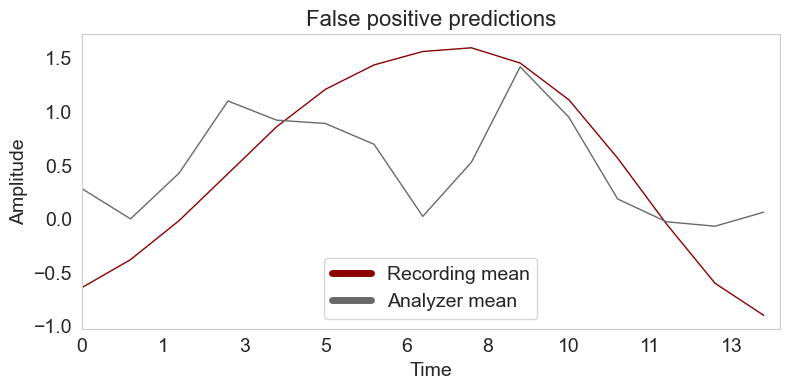

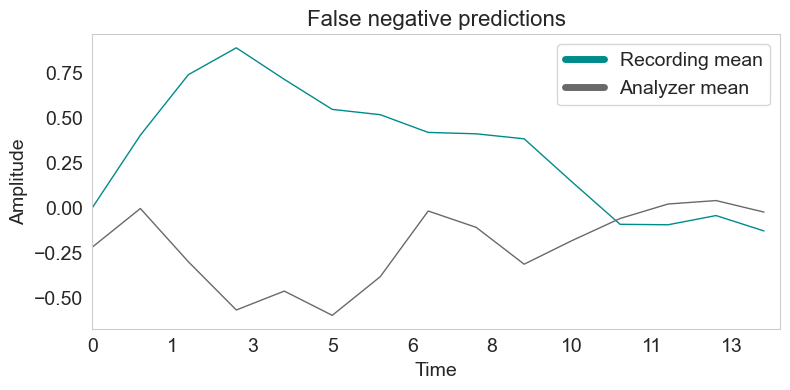

In [34]:

create_comparison_plot(full_model_XAIProject, binary_class_num = 1, multiple_class_num=False, prediction_quality = "false_positive", random_ = False, average_sample = True, average_analyzer = True)
create_comparison_plot(full_model_XAIProject, binary_class_num = 0, multiple_class_num=False, prediction_quality = "false_negative", random_ = False, average_sample = True, average_analyzer = True)

c:\Users\darab\anaconda3\envs\microneurography\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\darab\anaconda3\envs\microneurography\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
C:\Users\darab\AppData\Local\Temp\ipykernel_26876\1894229522.py:110: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{int(label)}" for label in adjusted_labels])


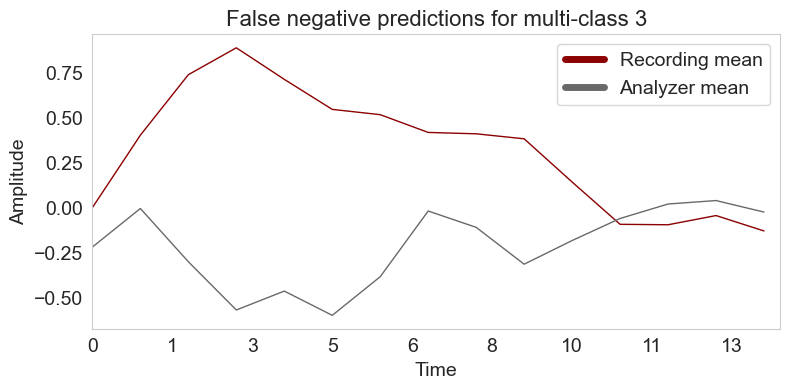

In [35]:
create_comparison_plot(full_model_XAIProject, binary_class_num = 1, multiple_class_num=1, prediction_quality = "false_negative", random_ = False, average_sample = True, average_analyzer = True)
create_comparison_plot(full_model_XAIProject, binary_class_num = 1, multiple_class_num=2, prediction_quality = "false_negative", random_ = False, average_sample = True, average_analyzer = True)
create_comparison_plot(full_model_XAIProject, binary_class_num = 1, multiple_class_num=3, prediction_quality = "false_negative", random_ = False, average_sample = True, average_analyzer = True)

C:\Users\darab\AppData\Local\Temp\ipykernel_26876\1894229522.py:110: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{int(label)}" for label in adjusted_labels])
C:\Users\darab\AppData\Local\Temp\ipykernel_26876\1894229522.py:110: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{int(label)}" for label in adjusted_labels])
C:\Users\darab\AppData\Local\Temp\ipykernel_26876\1894229522.py:110: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{int(label)}" for label in adjusted_labels])
C:\Users\darab\AppData\Local\Temp\ipykernel_26876\1894229522.py:110: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.

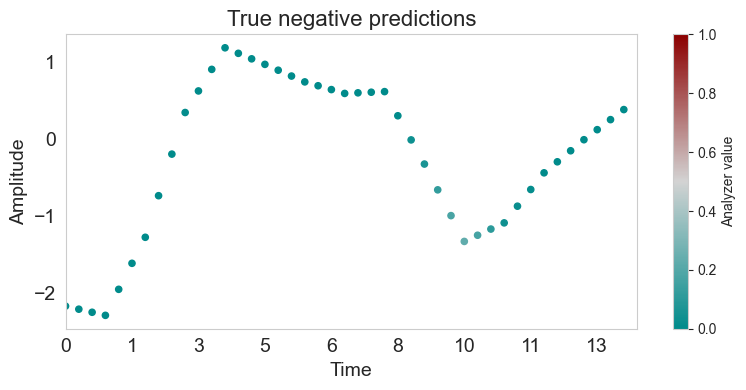

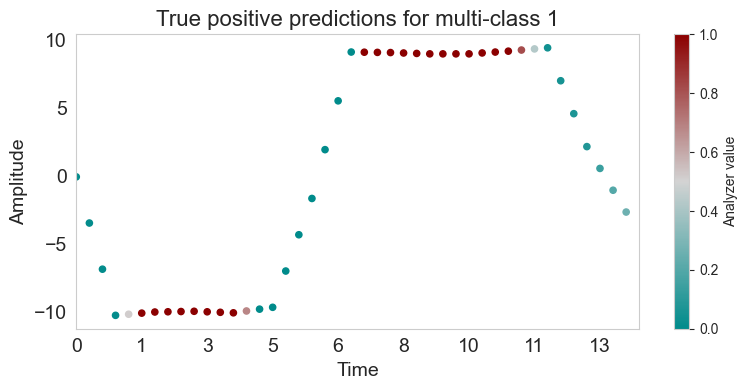

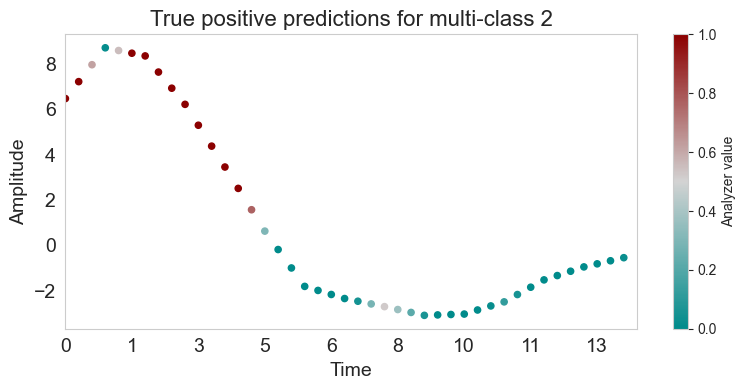

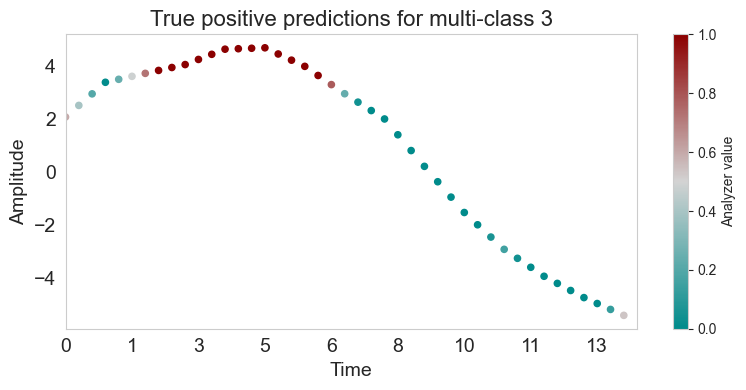

In [36]:
create_comparison_plot(full_model_XAIProject, binary_class_num = 0, multiple_class_num=False, prediction_quality = "correct", random_ = True, average_sample = False, average_analyzer = False)
create_comparison_plot(full_model_XAIProject, binary_class_num = 1, multiple_class_num=1, prediction_quality = "correct", random_ = True, average_sample = False, average_analyzer = False)
create_comparison_plot(full_model_XAIProject, binary_class_num = 1, multiple_class_num=2, prediction_quality = "correct", random_ = True, average_sample = False, average_analyzer = False)
create_comparison_plot(full_model_XAIProject, binary_class_num = 1, multiple_class_num=3, prediction_quality = "correct", random_ = True, average_sample = False, average_analyzer = False)

C:\Users\darab\AppData\Local\Temp\ipykernel_26876\1894229522.py:110: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{int(label)}" for label in adjusted_labels])
C:\Users\darab\AppData\Local\Temp\ipykernel_26876\1894229522.py:110: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{int(label)}" for label in adjusted_labels])


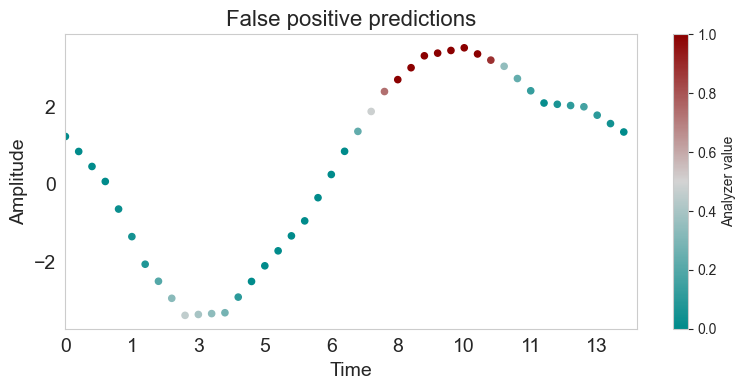

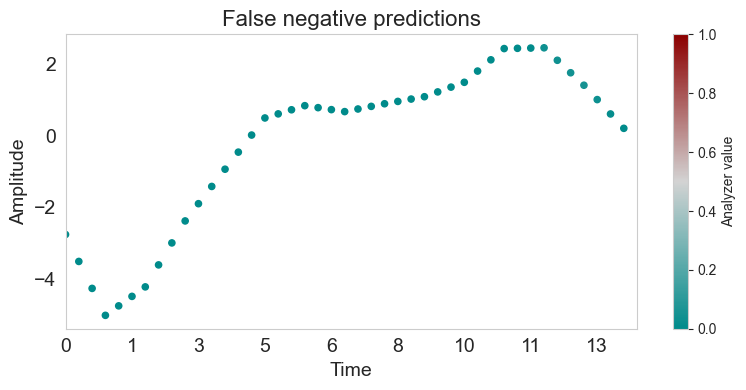

In [37]:
create_comparison_plot(full_model_XAIProject, binary_class_num = 1, multiple_class_num=False, prediction_quality = "false_positive", random_ = True, average_sample = False, average_analyzer = False)
create_comparison_plot(full_model_XAIProject, binary_class_num = 0, multiple_class_num=False, prediction_quality = "false_negative", random_ = True, average_sample = False, average_analyzer = False)

c:\Users\darab\anaconda3\envs\microneurography\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\darab\anaconda3\envs\microneurography\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
C:\Users\darab\AppData\Local\Temp\ipykernel_26876\1894229522.py:110: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{int(label)}" for label in adjusted_labels])


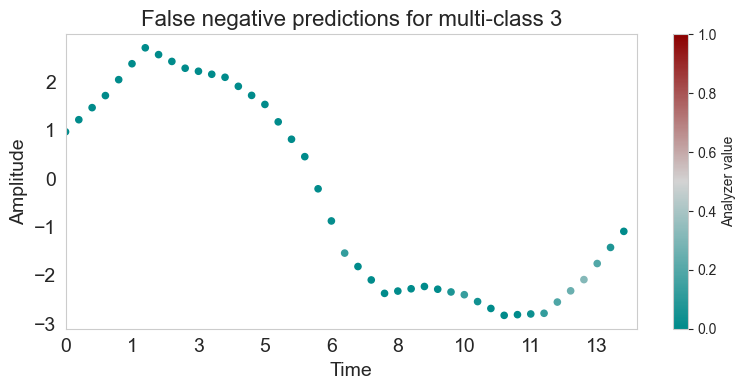

In [38]:
create_comparison_plot(full_model_XAIProject, binary_class_num = 1, multiple_class_num=1, prediction_quality = "false_negative", random_ = True, average_sample = False, average_analyzer = False)
create_comparison_plot(full_model_XAIProject, binary_class_num = 1, multiple_class_num=2, prediction_quality = "false_negative", random_ = True, average_sample = False, average_analyzer = False)
create_comparison_plot(full_model_XAIProject, binary_class_num = 1, multiple_class_num=3, prediction_quality = "false_negative", random_ = True, average_sample = False, average_analyzer = False)

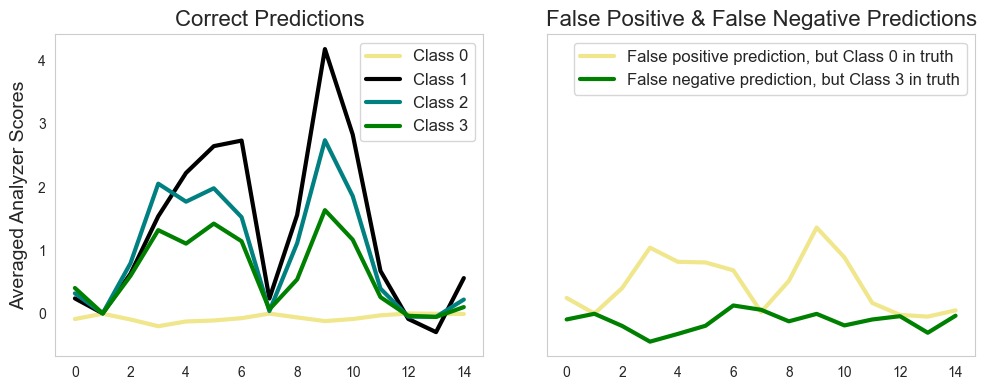

In [40]:
def plot_pred_quality_comparison(project: XAIProject):
    """
    Creates two subplots for average relevance scores: one for correct predictions and one combining false positive
    and false negative predictions.
    TODO: made for the loaded specific model.
    """
    fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
    titles = ["Correct Predictions", "False Positive & False Negative Predictions"]

    # First subplot: Correct predictions
    indices_for_class_0 = project.get_ture_neg_prediction_indices()
    indices_for_class_1 = project.get_true_positive_indices_for_multiple_class(1)
    indices_for_class_2 = project.get_true_positive_indices_for_multiple_class(2)
    indices_for_class_3 = project.get_true_positive_indices_for_multiple_class(3)

    analyzer_for_class_0 = project.analyzer_output[indices_for_class_0]
    analyzer_for_class_1 = project.analyzer_output[indices_for_class_1]
    analyzer_for_class_2 = project.analyzer_output[indices_for_class_2]
    analyzer_for_class_3 = project.analyzer_output[indices_for_class_3]

    analyzer_class_mean_0 = np.mean(analyzer_for_class_0, axis=0, keepdims=True)
    analyzer_class_mean_1 = np.mean(analyzer_for_class_1, axis=0, keepdims=True)
    analyzer_class_mean_2 = np.mean(analyzer_for_class_2, axis=0, keepdims=True)
    analyzer_class_mean_3 = np.mean(analyzer_for_class_3, axis=0, keepdims=True)

    ax = axes[0]
    ax.plot(analyzer_class_mean_0[0, :], label="Class 0", linewidth=3, color="khaki")
    ax.plot(analyzer_class_mean_1[0, :], label="Class 1", linewidth=3, color="black")
    ax.plot(analyzer_class_mean_2[0, :], label="Class 2", linewidth=3, color="teal")
    ax.plot(analyzer_class_mean_3[0, :], label="Class 3", linewidth=3, color="green")
    ax.set_title(titles[0], fontsize=16)
    #ax.set_xlabel("Time")
    ax.grid(False)
    ax.legend(fontsize=12)

    # Second subplot: False positive and false negative predictions
    indices_for_false_positive = project.get_false_positive_indices()
    indices_for_false_negative_0 = project.get_false_negative_indices()
    indices_for_false_negative_1 = project.get_false_negative_indices_for_multiple_class(1)
    indices_for_false_negative_2 = project.get_false_negative_indices_for_multiple_class(2)
    indices_for_false_negative_3 = project.get_false_negative_indices_for_multiple_class(3)

    analyzer_for_false_positive = project.analyzer_output[indices_for_false_positive]
    analyzer_for_false_negative_0 = project.analyzer_output[indices_for_false_negative_0]
    analyzer_for_false_negative_1 = project.analyzer_output[indices_for_false_negative_1]
    analyzer_for_false_negative_2 = project.analyzer_output[indices_for_false_negative_2]
    analyzer_for_false_negative_3 = project.analyzer_output[indices_for_false_negative_3]

    analyzer_mean_false_positive = np.mean(analyzer_for_false_positive, axis=0, keepdims=True)
    # analyzer_mean_false_negative_0 = np.mean(analyzer_for_false_negative_0, axis=0, keepdims=True)
    # analyzer_mean_false_negative_1 = np.mean(analyzer_for_false_negative_1, axis=0, keepdims=True)
    # analyzer_mean_false_negative_2 = np.mean(analyzer_for_false_negative_2, axis=0, keepdims=True)
    analyzer_mean_false_negative_3 = np.mean(analyzer_for_false_negative_3, axis=0, keepdims=True)

    ax = axes[1]
    ax.plot(analyzer_mean_false_positive[0, :], label="False positive prediction, but Class 0 in truth", linewidth=3, color="khaki")
    # ax.plot(analyzer_mean_false_negative_0[0, :], label="False Negative Class 0", linewidth=3)
    # ax.plot(analyzer_mean_false_negative_1[0, :], label="False Negative Class 1", linewidth=3)
    # ax.plot(analyzer_mean_false_negative_2[0, :], label="False Negative Class 2", linewidth=3)
    ax.plot(analyzer_mean_false_negative_3[0, :], label="False negative prediction, but Class 3 in truth", linewidth=3, color="green")
    ax.set_title(titles[1], fontsize=16)
    # ax.set_xlabel("Time")
    ax.legend(fontsize=12)

    # Shared y-label
    fig.supylabel("Averaged Analyzer Scores", fontsize=14)
    plt.grid(False)
    plt.tight_layout()
    plt.show()

plot_pred_quality_comparison(full_model_XAIProject)


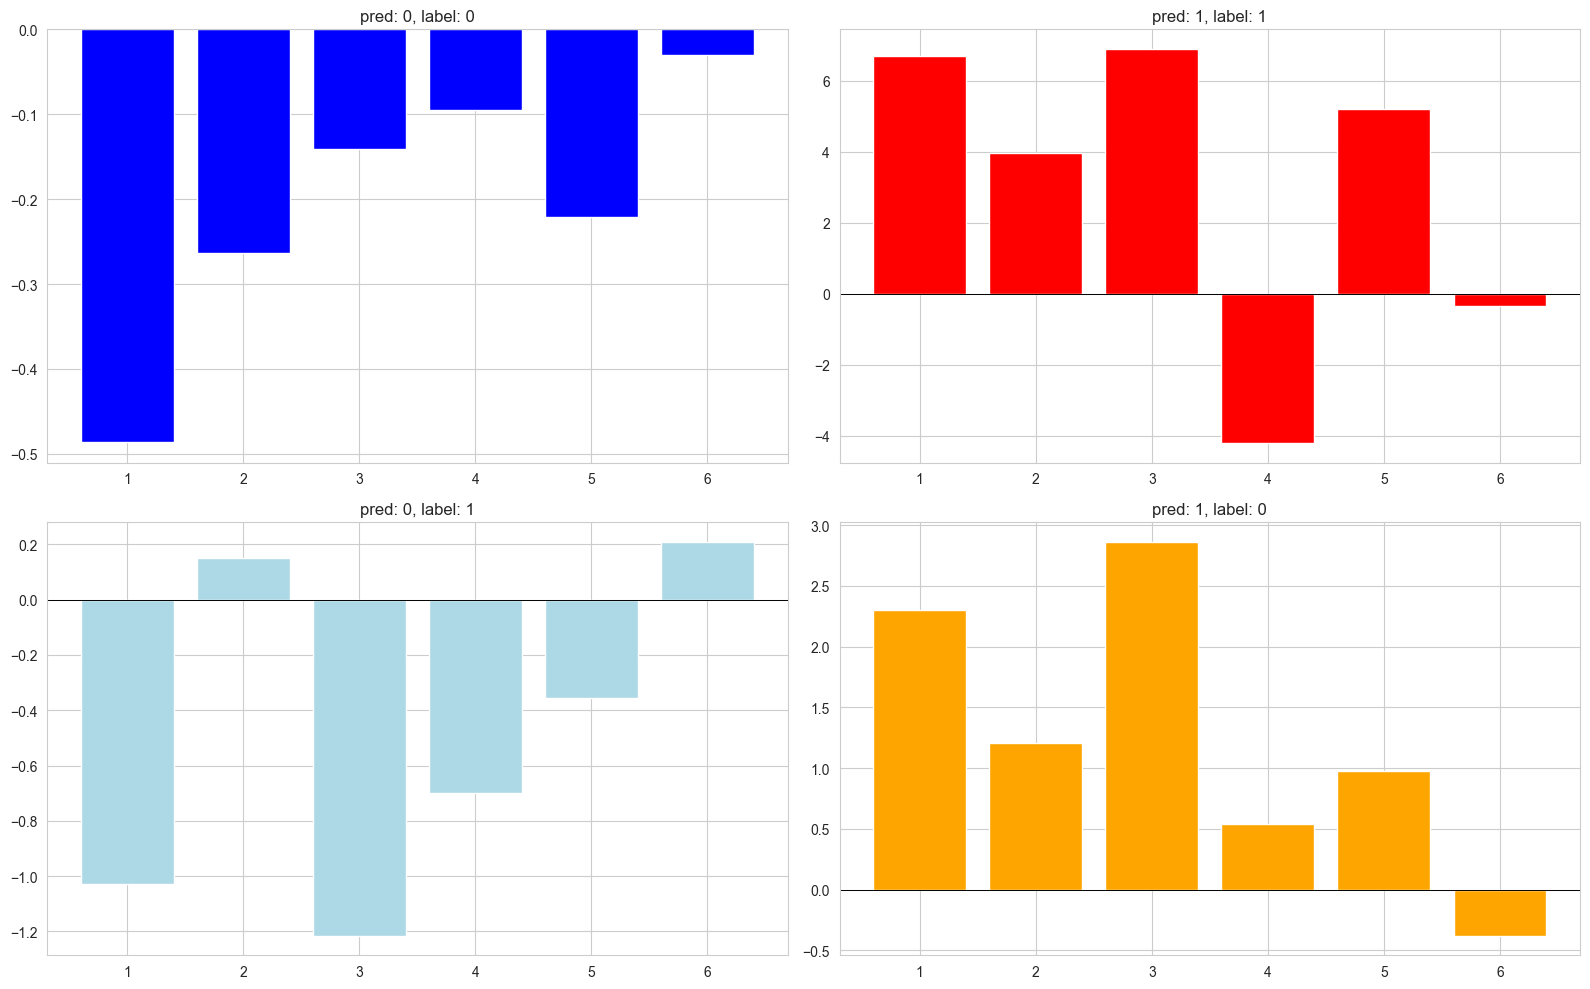

In [ ]:

def plot_avg_features_sep(project : XAIProject, ax, indices, title, color):
    values = project.analyzer_output[indices]
    avg_values = np.mean(values, axis=0)

    num_vars = len(avg_values)
    x = np.arange(num_vars)

    ax.bar(x, avg_values, color=color)

    ax.axhline(y=0, color='black', linewidth=0.7)

    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(np.arange(1, num_vars + 1))

indices_0 = np.intersect1d(np.where(feature_extractor_XAIProject.prediction_labels == 0)[0], np.where(feature_extractor_XAIProject.binary_labels == 0)[0])
indices_1 = np.intersect1d(np.where(feature_extractor_XAIProject.prediction_labels == 1)[0], np.where(feature_extractor_XAIProject.binary_labels == 1)[0])
indices_0_1 = np.intersect1d(np.where(feature_extractor_XAIProject.prediction_labels == 0)[0], np.where(feature_extractor_XAIProject.binary_labels == 1)[0])
indices_1_0 = np.intersect1d(np.where(feature_extractor_XAIProject.prediction_labels == 1)[0], np.where(feature_extractor_XAIProject.binary_labels == 0)[0])

fig, axs = plt.subplots(2, 2, figsize=(16, 10))

plot_avg_features_sep(feature_extractor_XAIProject, axs[0, 0], indices_0, "pred: 0, label: 0", color='blue')
plot_avg_features_sep(feature_extractor_XAIProject, axs[0, 1], indices_1, "pred: 1, label: 1", color='red')
plot_avg_features_sep(feature_extractor_XAIProject, axs[1, 0], indices_0_1, "pred: 0, label: 1", color='lightblue')
plot_avg_features_sep(feature_extractor_XAIProject, axs[1, 1], indices_1_0, "pred: 1, label: 0", color='orange')

plt.tight_layout()
plt.show()

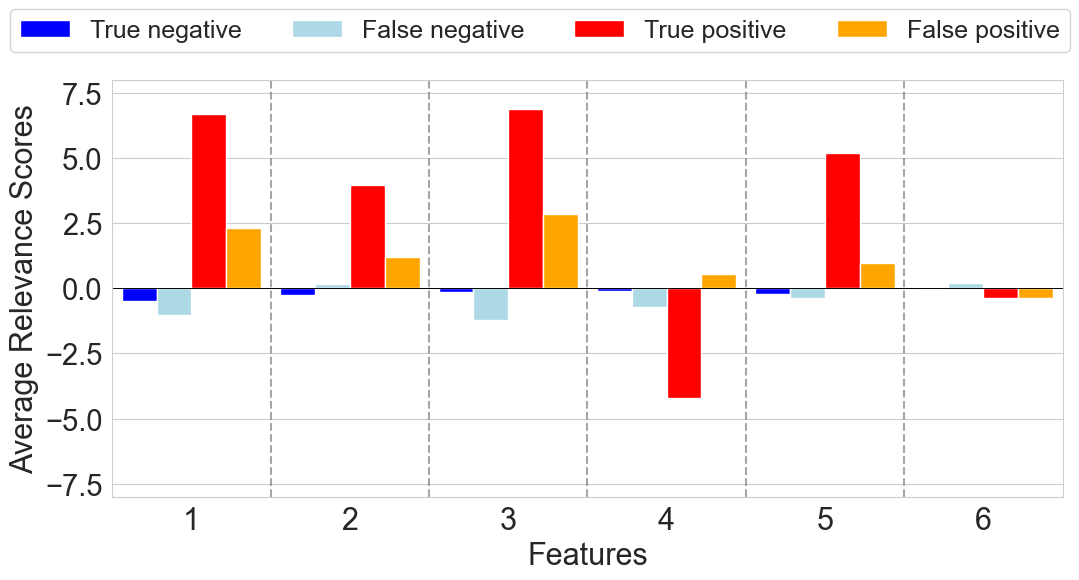

In [32]:
%matplotlib inline
def plot_avg_features_combined(project: XAIProject, ax, indices_list, labels, colors):
    avg_values_list = [np.mean(project.analyzer_output[indices], axis=0) for indices in indices_list]
    num_vars = len(avg_values_list[0])
    x = np.arange(num_vars)

    bar_width = 0.22
    padding = 0.5
    ax.set_xlim(-padding, num_vars - 1 + padding)
    offsets = [-1.5, -0.5, 0.5, 1.5]

    for avg_values, label, color, offset in zip(avg_values_list, labels, colors, offsets):
        ax.bar(x + offset * bar_width, avg_values, width=bar_width, label=label, color=color)

    ax.set_ylim(-8, 8)
    for i in range(1, num_vars):
        ax.vlines(x=i - 0.5, ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], color='gray', linestyle='--', alpha=0.7)

    ax.axhline(y=0, color='black', linewidth=0.7)
    ax.set_xticks(x)
    ax.set_xticklabels(np.arange(1, num_vars + 1), fontsize=22)
    ax.tick_params(axis='y', labelsize=21)
    ax.set_xlabel("Features",fontsize = 22)
    ax.set_ylabel("Average Relevance Scores",fontsize = 22)
    ax.legend(fontsize=18, bbox_to_anchor=(0.45, 1.2), loc='upper center', ncol=4)

indices_0 = np.intersect1d(
    np.where(feature_extractor_XAIProject.prediction_labels == 0)[0],
    np.where(feature_extractor_XAIProject.binary_labels == 0)[0]
)
indices_1 = np.intersect1d(
    np.where(feature_extractor_XAIProject.prediction_labels == 1)[0],
    np.where(feature_extractor_XAIProject.binary_labels == 1)[0]
)
indices_0_1 = np.intersect1d(
    np.where(feature_extractor_XAIProject.prediction_labels == 0)[0],
    np.where(feature_extractor_XAIProject.binary_labels == 1)[0]
)
indices_1_0 = np.intersect1d(
    np.where(feature_extractor_XAIProject.prediction_labels == 1)[0],
    np.where(feature_extractor_XAIProject.binary_labels == 0)[0]
)


indices_list = [indices_0, indices_0_1, indices_1, indices_1_0]
labels = ["True negative", "False negative", "True positive", "False positive"]
colors = ["blue", "lightblue", "red", "orange"]


fig, ax = plt.subplots(figsize=(12, 6))
plot_avg_features_combined(feature_extractor_XAIProject, ax, indices_list, labels, colors)
plt.grid(axis='x')
plt.subplots_adjust(left=0.2) 
plt.tight_layout()
plt.show()
